**CS-7643 - Deep Learning - Summer 2024 - Final Project - news_dataset_adaptertuning.ipynb**

**Group - Big Daaata**

Use SoTA models to the test on a News Category Classification dataset and compare the performance of a fine-tuned model against an adapter-based model. Being a Kaggle dataset from real-world data, it will help us quantify the advantages, if any, of the adapter-based models in a practical context.

This notebook has code to run experiments for one of the adapter baded models 
* google/electra-base-discriminator for adaptors that worked relatively well on superglue.

# Installs

In [1]:
!pip3 install datasets
!pip3 install evaluate
!pip3 install transformers
!pip3 install adapters
!pip3 install mlflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_metric
import numpy as np
import mlflow

# Load the dataset
# https://www.kaggle.com/datasets/rmisra/news-category-dataset/data
data_path = '/content/drive/MyDrive/CS7643-final-project/News_Category_Dataset_v3.json'  # set path to dataset
df = pd.read_json(data_path, lines=True)

# Keep relevant columns
df = df[['category', 'headline']]

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(df['category'].unique())}
df['label'] = df['category'].map(label_mapping)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'])

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['headline', 'label']])
val_dataset = Dataset.from_pandas(val_df[['headline', 'label']])
test_dataset = Dataset.from_pandas(test_df[['headline', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Check dataset
print(dataset)

num_labels = len(df['label'].unique())
print(f'Number of labels: {num_labels}')


DatasetDict({
    train: Dataset({
        features: ['headline', 'label', '__index_level_0__'],
        num_rows: 150858
    })
    validation: Dataset({
        features: ['headline', 'label', '__index_level_0__'],
        num_rows: 16763
    })
    test: Dataset({
        features: ['headline', 'label', '__index_level_0__'],
        num_rows: 41906
    })
})
Number of labels: 42


In [3]:
import torch
import numpy as np
import pandas as pd
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,  default_data_collator
from transformers import TrainerCallback, AutoConfig
import datasets
import matplotlib.pyplot as plt

from adapters import (
    AdapterArguments,
    AdapterTrainer,
    AutoAdapterModel,
    setup_adapter_training,   
    AdapterConfig, BnConfig, PrefixTuningConfig, MAMConfig, CompacterPlusPlusConfig,
    UniPELTConfig, IA3Config, LoRAConfig, PromptTuningConfig, ConfigUnion
)

# https://huggingface.co/docs/transformers/index
# Define model names
model_names = ['google/electra-base-discriminator']

# https://docs.adapterhub.ml/overview.html
string_to_config = {
#     'seq_bn': BnConfig(mh_adapter=True, output_adapter=True, reduction_factor=16, non_linearity="relu"),
#     'prefix_tuning': PrefixTuningConfig(flat=False, prefix_length=30),
#     'lora': LoRAConfig(r=8, alpha=16),
     'mam_adapter': MAMConfig(),
     'seq_bn_16_2_relu': ConfigUnion(
        BnConfig(mh_adapter=True, output_adapter=False, reduction_factor=16, non_linearity="relu"),
        BnConfig(mh_adapter=False, output_adapter=True, reduction_factor=2, non_linearity="relu"),
    ),
}


# Load metric
metric = load_metric('accuracy')
f1_metric = load_metric('f1')


# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, dim=-1).numpy()
    labels = np.array(labels)
    accuracy = metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Adapter', 'Epoch', 'Training Loss', 'Validation Loss', 'Accuracy', 'F1'])

# Callback to record metrics after each epoch
class MetricsCallback(TrainerCallback):
    def __init__(self, adapter):
        self.adapter = adapter
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_world_process_zero:
            logs = logs or {}
            epoch = state.epoch
            model_name = args.output_dir.split('/')[-1]
            adapter_name = self.adapter if self.adapter else 'none'
            training_loss = logs.get('loss', None)
            validation_loss = logs.get('eval_loss', None)
            accuracy = logs.get('eval_accuracy', None)
            f1 = logs.get('eval_f1', None)
            new_row = pd.DataFrame([[model_name, adapter_name, epoch, training_loss, validation_loss, accuracy, f1]], columns=['Model', 'Adapter', 'Epoch', 'Training Loss', 'Validation Loss', 'Accuracy', 'F1'])
            
            if not new_row.isna().all(axis=1).any():
                global results_df
                results_df = pd.concat([results_df, new_row], ignore_index=True)

# Function to fine-tune a model
def fine_tune_model(model_name, adapter=False, adapter_type=None):
    global results_df

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if adapter:
#         model = AutoAdapterModel.from_pretrained(model_name)
#         model.add_classification_head("mrpc", num_labels=42)
#         model.add_adapter("mrpc", config=adapter_type)
#         model.set_active_adapters("mrpc")
        model = AutoAdapterModel.from_pretrained(model_name)
        model.add_classification_head(adapter_type, num_labels=42)
        adapter_config = string_to_config.get(adapter_type)
        if adapter_type=='prefix_tuning':
            model.eject_prefix_tuning("prefix_tuning")
        model.add_adapter(adapter_type, config=adapter_config)
        model.train_adapter(adapter_type)
        model.set_active_adapters(adapter_type)

            
    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))
    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(examples['headline'], truncation=True, padding='max_length', max_length=128)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        evaluation_strategy='epoch',
        learning_rate=5e-6,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=10,
        weight_decay=0.02,
        save_total_limit=1,
        eval_steps=1,
        save_strategy='epoch',
        logging_strategy='steps',
        logging_first_step=True,
        load_best_model_at_end=True,
        logging_steps=1,
        report_to="mlflow",
    )
    
    # Data collator
    data_collator = default_data_collator
    
    # Trainer
    trainer_class = AdapterTrainer if adapter else Trainer
    trainer = trainer_class(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        compute_metrics=compute_metrics,
        callbacks=[MetricsCallback(adapter_type)]
    )
    
    # Add print statements to debug batch sizes
    for step, batch in enumerate(trainer.get_train_dataloader()):
        inputs, labels = batch["input_ids"], batch["labels"]
        print(f"Batch {step}: input size {inputs.size()}, label size {labels.size()}")
        if step == 1:  # Print only the first batch
            break


    # Train model
    trainer.train()

    # Evaluate model
    eval_results = trainer.evaluate(eval_dataset=tokenized_datasets['test'])
    print(f"Evaluation results for {model_name}: {eval_results}")



# Fine-tune each model
# for model_name in model_names:
#     fine_tune_model(model_name)
    
# # Fine-tune each model with each adapter
# for model_name in model_names:
#     for adapter_type in string_to_config.keys():
#         print("model_name: ", model_name, " - adapter_type: ", adapter_type )
#         fine_tune_model(model_name, adapter=True, adapter_type=adapter_type)


/scratch/643290/ipykernel_1914432/1740407153.py:36: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot learning curves for all models and adapters
def plot_learning_curves(results_df):
    # Get unique model and adapter names
    model_names = results_df['Model'].unique()
    adapter_names = results_df['Adapter'].unique()

    for model_name in model_names:
        for adapter_name in adapter_names:
            model_adapter_results = results_df[(results_df['Model'] == model_name) & (results_df['Adapter'] == adapter_name)]

            if model_adapter_results.empty:
                continue

            # Round the epoch values to ensure proper grouping
            model_adapter_results['Epoch'] = model_adapter_results['Epoch'].round()

            # Filter to get the last training loss entry per epoch
            avg_training_loss_per_epoch = model_adapter_results.dropna(subset=['Training Loss']).groupby('Epoch')['Training Loss'].mean().reset_index()
            print(avg_training_loss_per_epoch)
            last_validation_loss_per_epoch = model_adapter_results.dropna(subset=['Validation Loss']).groupby('Epoch')['Validation Loss'].last().reset_index()

            # Merge the training and validation losses
            merged_results = pd.merge(avg_training_loss_per_epoch, last_validation_loss_per_epoch, on='Epoch', how='outer')

            plt.plot(merged_results['Epoch'], merged_results['Training Loss'], label='Training Loss', marker='o')
            plt.plot(merged_results['Epoch'], merged_results['Validation Loss'], label='Validation Loss', marker='o')

            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Learning Curves for {model_name} with Adapter {adapter_name}')
            plt.legend()
            plt.grid(True)
            plt.show()


In [5]:
# model_names = ['distilbert-base-uncased','facebook/bart-base', 'google/electra-base-discriminator']

model_name = 'google/electra-base-discriminator'
for adapter_type in string_to_config.keys():
    print("model_name: ", model_name, " - adapter_type: ", adapter_type )
    fine_tune_model(model_name, adapter=True, adapter_type=adapter_type)

model_name:  google/electra-base-discriminator  - adapter_type:  mam_adapter


/home/hice1/ksingh362/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/150858 [00:00<?, ? examples/s]

Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

Map:   0%|          | 0/41906 [00:00<?, ? examples/s]

Batch 0: input size torch.Size([32, 128]), label size torch.Size([32])
Batch 1: input size torch.Size([32, 128]), label size torch.Size([32])


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.565900,1.864510,0.520074,0.432792
2,0.969600,1.624739,0.564100,0.507341
3,2.097700,1.518595,0.582951,0.536736
4,1.478800,1.453541,0.597566,0.564672
5,1.959300,1.414869,0.603233,0.579061
6,1.315100,1.396197,0.607469,0.581593
7,1.317900,1.381732,0.613434,0.591387
8,1.328100,1.366871,0.617670,0.593647
9,1.228400,1.359149,0.615582,0.597152
10,2.118300,1.352254,0.617908,0.599449


/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/home/hice1/ksingh362/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Evaluation results for google/electra-base-discriminator: {'eval_loss': 1.3485984802246094, 'eval_accuracy': 0.6180499212523266, 'eval_f1': 0.5996322681058471, 'eval_runtime': 86.9881, 'eval_samples_per_second': 481.744, 'eval_steps_per_second': 7.53, 'epoch': 10.0}
model_name:  google/electra-base-discriminator  - adapter_type:  seq_bn_16_2_relu


Map:   0%|          | 0/150858 [00:00<?, ? examples/s]

Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

Map:   0%|          | 0/41906 [00:00<?, ? examples/s]

Batch 0: input size torch.Size([32, 128]), label size torch.Size([32])
Batch 1: input size torch.Size([32, 128]), label size torch.Size([32])


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.472400,2.287994,0.411979,0.304379
2,1.479700,1.984915,0.480045,0.391534
3,2.040800,1.820593,0.517628,0.440256
4,2.090400,1.743698,0.535047,0.472294
5,2.597800,1.685424,0.547396,0.493568
6,1.585700,1.641567,0.557478,0.506157
7,1.312400,1.620908,0.564100,0.520890
8,1.356400,1.598222,0.569051,0.527089
9,1.099100,1.587435,0.570363,0.531237
10,2.732900,1.584028,0.571437,0.532674


/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

Evaluation results for google/electra-base-discriminator: {'eval_loss': 1.5862951278686523, 'eval_accuracy': 0.5682479835823032, 'eval_f1': 0.5300390083909973, 'eval_runtime': 83.9033, 'eval_samples_per_second': 499.456, 'eval_steps_per_second': 7.807, 'epoch': 10.0}


/scratch/643290/ipykernel_1914432/1740407153.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


# Plots

Exception ignored in: <function MLflowCallback.__del__ at 0x15545b8e5ea0>
Traceback (most recent call last):
  File "/home/hice1/ksingh362/.local/lib/python3.10/site-packages/transformers/integrations/integration_utils.py", line 1111, in __del__
    self._ml_flow.end_run()
  File "/home/hice1/ksingh362/.local/lib/python3.10/site-packages/mlflow/tracking/fluent.py", line 456, in end_run
    MlflowClient().set_terminated(_last_active_run_id, status)
  File "/home/hice1/ksingh362/.local/lib/python3.10/site-packages/mlflow/tracking/client.py", line 2880, in set_terminated
    self._tracking_client.set_terminated(run_id, status, end_time)
  File "/home/hice1/ksingh362/.local/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/client.py", line 888, in set_terminated
    self.store.end_async_logging()
  File "/home/hice1/ksingh362/.local/lib/python3.10/site-packages/mlflow/store/tracking/abstract_store.py", line 629, in end_async_logging
    self._async_logging_queue.end_async_logg

    Epoch  Training Loss
0     0.0       2.689163
1     1.0       1.940819
2     2.0       1.665690
3     3.0       1.536104
4     4.0       1.461921
5     5.0       1.413137
6     6.0       1.371053
7     7.0       1.343125
8     8.0       1.319200
9     9.0       1.303660
10   10.0       1.295920


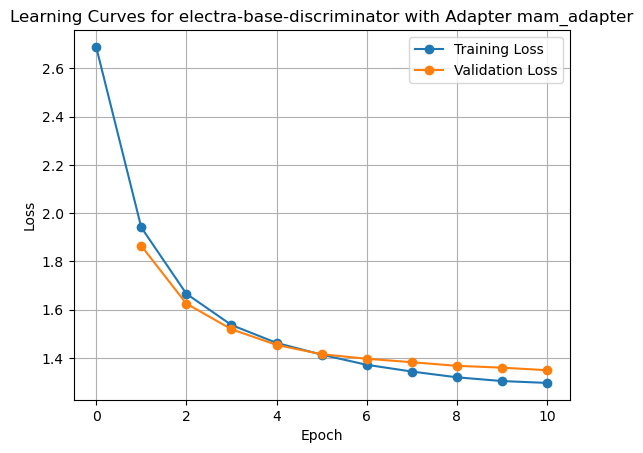

/scratch/643290/ipykernel_1914432/2037164542.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_adapter_results['Epoch'] = model_adapter_results['Epoch'].round()


    Epoch  Training Loss
0     0.0       2.991278
1     1.0       2.383368
2     2.0       2.069617
3     3.0       1.894877
4     4.0       1.802056
5     5.0       1.742307
6     6.0       1.703331
7     7.0       1.666588
8     8.0       1.647727
9     9.0       1.637658
10   10.0       1.629988


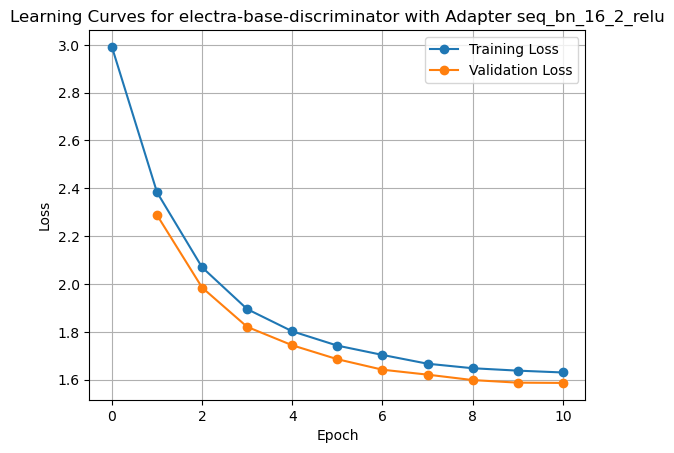

In [6]:
results_df.to_csv('model_results.csv', index=False)
# Call the function to plot learning curves
plot_learning_curves(results_df)